In [77]:
%load_ext autoreload
%autoreload 2

import sys

# implementation of reverse_shuffle
sys.path.insert(0, "/Users/user/git/eli5/")
import eli5

sys.path.insert(0, "/Users/user/git/datasci")
from sci.metrics import rmse, rmse_score, neg_rmse_score
import sci.plots as scip
import sci.learn as sci

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
pd.set_option('display.float_format', lambda x: '{:.5f}'.format(x)) #Limiting floats output to 3 decimal points
pd.options.display.max_rows = 1000

random_state = 7

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

In [214]:
# data_top2 = sci.load_data("processed_top2")
# data_top10 = sci.load_data("processed_top10")
# data_old = sci.load_data("processed_old")
# data_new = sci.load_data("processed_new")
data_my = sci.load_data("processed_my")
data_top1 = sci.load_data("processed_top1")
data_minimal = sci.load_data("processed_minimal")

data = data_minimal

print("train:", data.X_train.shape)
print("test:", data.X_test.shape)

(1439, 163) (1439,)
(1426, 289) (1426,)
(1441, 288) (1441,)
train: (1152, 288)
test: (289, 288)


In [55]:
# from scipy.special import boxcox, inv_boxcox
# from scipy.stats import boxcox_normmax

# boxcox_lambda = boxcox_normmax(data.y)
# data.y = boxcox(data.y, boxcox_lambda)
# data.y_train = data.y.loc[data.y_train.index]
# data.y_test = data.y.loc[data.y_test.index]

# # boxcox_lambda = boxcox_normmax(data.y_train)
# # data.y_train = boxcox(data.y_train, boxcox_lambda)
# # data.y_test = boxcox(data.y_test, boxcox_lambda)


# print(f'optimal lambda: {boxcox_lambda}')

optimal lambda: -0.23578589514391374


## Choose Model

In [156]:
from sklearn.model_selection import *

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.linear_model import *
from sklearn import svm
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import *
from sklearn.ensemble import RandomForestClassifier

import xgboost
from xgboost import XGBClassifier, XGBRegressor

import lightgbm as lgb
from lightgbm import LGBMRegressor

from MeanModel import MeanModels
from StackingAveragedModels import StackingAveragedModels

In [157]:
top2_elastic_net = make_pipeline(RobustScaler(), ElasticNet(max_iter=1e7, alpha=0.0007, l1_ratio=1))
top2_lasso = make_pipeline(RobustScaler(), Lasso(max_iter=1e7, alpha = 0.0008))
top2_ridge = make_pipeline(RobustScaler(), Ridge(alpha = 15.5))

top2_xgb = XGBRegressor(learning_rate=0.01, n_estimators=3460, max_depth=3,
                     min_child_weight=0 ,gamma=0, subsample=0.7,
                     colsample_bytree=0.7,objective= 'reg:linear',
                     nthread=4,scale_pos_weight=1,seed=27, reg_alpha=0.00006)

top2_lgbm = LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

top2_svr = svm.SVR(C = 100000, gamma = 1e-08)

models_top2 = {}
models_top2['top2_elastic_net'] = top2_elastic_net
models_top2['top2_lasso'] = top2_lasso
models_top2['top2_ridge'] = top2_ridge
models_top2['top2_xgb'] = top2_xgb
models_top2['top2_lgbm'] = top2_lgbm


models_top2['top2_svr'] = top2_svr


In [158]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=23)


e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]
top2_elastic_model3 = make_pipeline(RobustScaler(), 
                           ElasticNetCV(max_iter=1e7, alphas=e_alphas, 
                                        cv=kfolds, l1_ratio=e_l1ratio))

alphas = [0.00005, 0.0001, 0.0003, 0.0005, 0.0007, 
          0.0009, 0.01]
alphas2 = [0.00005, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005,
           0.0006, 0.0007, 0.0008]
top2_lasso_model2 = make_pipeline(RobustScaler(),
                             LassoCV(max_iter=1e7,
                                    alphas = alphas2,
                                    random_state = 42))


alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
top2_ridge_model2 = make_pipeline(RobustScaler(),
                            RidgeCV(alphas = alphas_alt,
                                    cv=kfolds))


top2_xgb_fit = XGBRegressor(learning_rate =0.01, n_estimators=3460, max_depth=3,
                     min_child_weight=0 ,gamma=0, subsample=0.7,
                     colsample_bytree=0.7,objective= 'reg:linear',
                     nthread=4,scale_pos_weight=1,seed=27, reg_alpha=0.00006)


svr_fit = svm.SVR(C = 100000, gamma = 1e-08)

top2_lgbm_model = LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

# ====================================

from mlxtend.regressor import StackingCVRegressor
from sklearn.pipeline import make_pipeline

#setup models
top2_ridge = make_pipeline(RobustScaler(), 
                      RidgeCV(alphas = alphas_alt, cv=kfolds))

top2_lasso = make_pipeline(RobustScaler(),
                      LassoCV(max_iter=1e7, alphas = alphas2,
                              random_state = 42, cv=kfolds))

top2_elasticnet = make_pipeline(RobustScaler(), 
                           ElasticNetCV(max_iter=1e7, alphas=e_alphas, 
                                        cv=kfolds, l1_ratio=e_l1ratio))

top2_lightgbm = make_pipeline(RobustScaler(),
                        LGBMRegressor(objective='regression',num_leaves=5,
                                      learning_rate=0.05, n_estimators=720,
                                      max_bin = 55, bagging_fraction = 0.8,
                                      bagging_freq = 5, feature_fraction = 0.2319,
                                      feature_fraction_seed=9, bagging_seed=9,
                                      min_data_in_leaf =6, 
                                      min_sum_hessian_in_leaf = 11))

top2_xgboost = make_pipeline(RobustScaler(),
                        XGBRegressor(learning_rate =0.01, n_estimators=3460, 
                                     max_depth=3,min_child_weight=0 ,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective= 'reg:linear',nthread=4,
                                     scale_pos_weight=1,seed=27, 
                                     reg_alpha=0.00006))


#stack
top2_stack_gen_model = StackingCVRegressor(regressors=(top2_ridge, top2_lasso, top2_elasticnet, 
                                            top2_xgboost, top2_lightgbm), 
                               meta_regressor=xgboost,
                               use_features_in_secondary=True)


top_2_final_model = MeanModels([top2_elastic_model3, top2_lasso_model2, top2_ridge_model2, top2_xgb_fit, top2_lgbm_model, top2_stack_gen_model], 
                               weights=[0.2, 0.1, 0.1, 0.2, 0.1, 0.3])

In [159]:
# ridge
l2Regr = Ridge(alpha=9.0, fit_intercept = True)
# lasso
l1Regr = make_pipeline(RobustScaler(), Lasso(alpha = 0.0003, random_state=1, max_iter=50000))
# GBR      
myGBR = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.02,
                                  max_depth=4, max_features='sqrt',
                                  min_samples_leaf=15, min_samples_split=50,
                                  loss='huber', random_state = 5) 
# ENet
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=4.0, l1_ratio=0.005, random_state=3))
# LGB
myLGB = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                          learning_rate=0.05, n_estimators=600,
                          max_bin = 50, bagging_fraction = 0.6,
                          bagging_freq = 5, feature_fraction = 0.25,
                          feature_fraction_seed=9, bagging_seed=9,
                          min_data_in_leaf = 6, min_sum_hessian_in_leaf = 11)

models_top10 = {}
models_top10['top10_l2Regr'] = l2Regr
models_top10['top10_l1Regr'] = l1Regr
models_top10['top10_myGBR'] = myGBR
models_top10['top10_ENet'] = ENet
models_top10['top10_myLGB'] = myLGB

meanModel_top10  = MeanModels(models_top10)
stackModel_top10 = StackingAveragedModels(models_top10, meta_model=ElasticNet(alpha=0.0005, random_state=1))

In [160]:
# # MY final models (Cross-Validated on the entire train set)
# # On data_my DATA

# my_lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.00016641681352708363))

# my_enet = make_pipeline(RobustScaler(), ElasticNet())
# my_enet.set_params(**{'elasticnet__alpha': 0.0030467854763687155, 'elasticnet__l1_ratio': 0.09073628110603828})

# my_ridge = Ridge(alpha=7.363511048535817)
# my_krr = KernelRidge()
# # my_krr_poly = KernelRidge(alpha=4675, kernel='polynomial', degree=2, coef0=931)

# my_xgb = XGBRegressor()
# my_xgb.set_params(**{'colsample_bylevel': 0.7231730729084673, 'colsample_bytree': 0.599675349914106, 'gamma': 4.963870505799037e-07, 'learning_rate': 0.007236097391100767, 'max_depth': 20, 'min_child_weight': 7, 'n_estimators': 2094, 'reg_alpha': 0.25613997536873956, 'reg_lambda': 8.410365875575881e-05, 'scale_pos_weight': 1.346706533698459, 'subsample': 0.4376597688998189})

# my_lgbm = LGBMRegressor()
# my_lgbm.set_params(**{'bagging_fraction': 0.7144454032979745, 'bagging_freq': 76, 'feature_fraction': 0.44239421741696816, 'learning_rate': 0.005684198391561915, 'max_bin': 49, 'max_depth': 15, 'min_data_in_leaf': 16, 'min_sum_hessian_in_leaf': 14, 'n_estimators': 3950, 'num_leaves': 4})

# my_skgb = GradientBoostingRegressor()
# my_skgb.set_params(**{'learning_rate': 0.07918682823722076, 'loss': 'ls', 'max_depth': 11, 'max_features': 'sqrt', 'min_samples_leaf': 18, 'min_samples_split': 7, 'n_estimators': 100})

# models_my = {}
# models_my['my_lasso'] = my_lasso
# models_my['my_enet'] = my_enet
# models_my['my_ridge'] = my_ridge
# models_my['my_krr'] = my_krr
# # models_my['my_krr_poly'] = my_krr_poly
# models_my['my_xgb'] = my_xgb
# models_my['my_lgbm'] = my_lgbm
# models_my['my_skgb'] = my_skgb

# my_meanModel = MeanModels(dict(models_my))
# my_stackModel = StackingAveragedModels(dict(models_my), meta_model=ElasticNet(alpha=0.0005, random_state=1))
# my_stackModel_noCV = StackingAveragedModels(dict(models_my), meta_model=ElasticNet(alpha=0.0005, random_state=1))

# models_my_plus = dict(models_my)
# models_my_plus['my_meanModel'] = my_meanModel
# models_my_plus['my_stackModel'] = my_stackModel



In [161]:
# MY final models (Cross-Validated on the entire train set)
# On top_1 DATA

my_lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0003298710695449572))

my_enet = make_pipeline(RobustScaler(), ElasticNet())
my_enet.set_params(**{'elasticnet__alpha': 0.0002468735796831351, 'elasticnet__l1_ratio': 0.46722248108864484})

my_ridge = make_pipeline(RobustScaler(), Ridge())
my_ridge.set_params(**{'ridge__alpha': 9.148308926229664})


# my_krr = KernelRidge()
# my_krr_poly = KernelRidge(alpha=4675, kernel='polynomial', degree=2, coef0=931)

my_xgb = XGBRegressor()
my_xgb.set_params(**{'colsample_bylevel': 0.17870763786940358, 'colsample_bytree': 0.8777244680416619, 'gamma': 0.00020997932250413186, 'learning_rate': 0.009909994865235198, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 3666, 'reg_alpha': 0.01682901591458505, 'reg_lambda': 0.003143187137552337, 'subsample': 0.334238047240377})

my_lgbm = LGBMRegressor()
my_lgbm.set_params(**{'bagging_fraction': 0.9797856812445304, 'bagging_freq': 98, 'feature_fraction': 0.34036022892382006, 'learning_rate': 0.007893758994629015, 'max_bin': 55, 'max_depth': 6, 'min_data_in_leaf': 20, 'min_sum_hessian_in_leaf': 20, 'n_estimators': 3138, 'num_leaves': 6})

my_skgb = GradientBoostingRegressor()
my_skgb.set_params(**{'learning_rate': 0.03934387438793518, 'loss': 'ls', 'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 15, 'min_samples_split': 14, 'n_estimators': 1774})

models_my = {}
models_my['my_lasso'] = my_lasso
models_my['my_enet'] = my_enet
models_my['my_ridge'] = my_ridge
# models_my['my_krr'] = my_krr
# models_my['my_krr_poly'] = my_krr_poly
models_my['my_xgb'] = my_xgb
models_my['my_lgbm'] = my_lgbm
models_my['my_skgb'] = my_skgb

my_meanModel = MeanModels(dict(models_my))
my_meanModel2 = MeanModels({'my_lasso': my_lasso, 'my_xgb': my_xgb})
my_stackModel = StackingAveragedModels(dict(models_my), meta_model=ElasticNet(alpha=0.0005, random_state=1))
my_stackModel_noCV = StackingAveragedModels(dict(models_my), meta_model=ElasticNet(alpha=0.0005, random_state=1))

models_my_plus = dict(models_my)
models_my_plus['my_meanModel'] = my_meanModel
models_my_plus['my_stackModel'] = my_stackModel



In [162]:
my_meanModel_scaler = make_pipeline(RobustScaler(), MeanModels(dict(models_my)))


In [163]:
top1_gbr = GradientBoostingRegressor(max_depth=4, n_estimators=150)
top1_xgbr = XGBRegressor(max_depth=5, n_estimators=400)
top1_lsr = Lasso(alpha=0.00047)
top1_rr = Ridge(alpha=13)

models_top1 = {}
models_top1['top1_gbr'] = top1_gbr
models_top1['top1_xgbr'] = top1_xgbr
models_top1['top1_lsr'] = top1_lsr
models_top1['top1_rr'] = top1_rr

top1_meanModel = MeanModels(dict(models_top1))
top1_weighedModel = MeanModels(dict(models_top1), weights=[0.1, 0.3, 0.3, 0.3])
top1_stackModel = StackingAveragedModels(dict(models_top1), meta_model=ElasticNet(alpha=0.0005, random_state=1))



In [164]:
# Fine-tuned models

xgb_best = XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213,
                             random_state = 7)

lgbm_best = lgb.LGBMRegressor(objective='regression',
                              importance_type='gain', # same as xgboost
                              num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

GBoost_best = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state=5)

# ENet_model = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
ENet_best = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=1.0))

KRR_best = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

In [165]:
# gradient boosting models
models_best = {}
models_best['GBoost_best'] = GBoost_best
models_best['xgb_best'] = xgb_best
models_best['lgbm_best'] = lgbm_best
models_best['ENet_best'] = ENet_best
models_best['KRR_best'] = KRR_best

meanModel_best  = MeanModels(models_best)
stackModel_best = StackingAveragedModels(models_best, meta_model=ElasticNet(alpha=0.0005, random_state=1))

In [166]:
# Generalized Linear Models - default params
models_glm = [
    # interesting
    BayesianRidge,
    HuberRegressor,
    
    # CV work well out-of-box
    ElasticNetCV,
    RidgeCV,
    LassoCV,
    LarsCV,
    LassoLarsCV,
    OrthogonalMatchingPursuitCV,
    
    # same as above, but without CV
    ElasticNet,
    Ridge,
    Lasso,
#     Lars,  # valid, but have aweful results out-of-box
    LassoLars,
    OrthogonalMatchingPursuit,
    
    # Other
    ARDRegression,
    LassoLarsIC,
    LinearRegression,
    PassiveAggressiveRegressor,
    RANSACRegressor,
#     TheilSenRegressor, # ok, but slow
#     SGDRegressor,  # valid, but have aweful results out-of-box
]

def create_model_with_random_state(model_class, random_state):
    try:
        model = model_class(random_state=random_state)
    except:
        model = model_class()
    return model

models_glm = {model.__name__: create_model_with_random_state(model, random_state) for model in models_glm}

meanModel_glm  = MeanModels(models_glm)
stackModel_glm = StackingAveragedModels(models_glm, meta_model=ElasticNet(alpha=0.0005, random_state=1))

In [167]:
# gradient boosting models
models_gb = {}
models_gb['GBoost_model'] = GBoost_best
models_gb['xgb_best'] = xgb_best
models_gb['lgbm_best'] = lgbm_best

meanModel_gb  = MeanModels(models_gb)
stackModel_gb = StackingAveragedModels(models_gb, meta_model=ElasticNet(alpha=0.0005, random_state=1))

In [168]:
# other models and fine-tuned GLM models
models_other = {}
models_other['ENet_best'] = ENet_best
models_other['KRR_def'] = KernelRidge()
models_other['KRR_best'] = KRR_best

meanModel_other  = MeanModels(models_other)
stackModel_other = StackingAveragedModels(models_other, meta_model=ElasticNet(alpha=0.0005, random_state=1))

In [169]:
# all base models
models_all = {**models_glm, **models_gb, **models_other, **models_top10, **models_my}

meanModel_all  = MeanModels(models_all)
stackModel_all = StackingAveragedModels(models_all, meta_model=ElasticNet(alpha=0.0005, random_state=1))

In [170]:
# mean and stack over the stackModels
models_mean = {}
models_mean['meanModel_glm'] = meanModel_glm
models_mean['meanModel_gb'] = meanModel_gb
models_mean['meanModel_other'] = meanModel_other
models_mean['meanModel_best'] = meanModel_best
models_mean['meanModel_all'] = meanModel_all


models_stack = {}
models_stack['stackModel_glm'] = stackModel_glm
models_stack['stackModel_gb'] = stackModel_gb
models_stack['stackModel_other'] = stackModel_other

meanModel_stackModels = MeanModels(dict(models_stack))
stackModel_stackModel = StackingAveragedModels(dict(models_stack), meta_model=ElasticNet(alpha=0.0005, random_state=1))

models_stack['stackModel_best'] = stackModel_best
models_stack['stackModel_all'] = stackModel_all

models_hyperStack = {}
models_hyperStack['meanModel_stackModels'] = meanModel_stackModels
models_hyperStack['stackModel_stackModel'] = stackModel_stackModel


In [171]:
models_comp = {**models_all, **models_stack, **models_mean}
models_comp = {**models_all, **models_my}


In [172]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_jobs=10)

In [186]:
# minimal

min_xgb = XGBRegressor()
min_xgb.set_params(**{'colsample_bylevel': 0.8115743305978224, 'colsample_bytree': 0.5301535059034544, 'gamma': 0.0003231279218929991, 'learning_rate': 0.03245045949207398, 'max_depth': 8, 'min_child_weight': 7, 'n_estimators': 1352, 'reg_alpha': 1.2671825075675193e-07, 'reg_lambda': 1.4670218763052504e-08, 'subsample': 0.2338671560043425})

min_enet = make_pipeline(RobustScaler(), ElasticNet())
min_enet.set_params(**{'elasticnet__alpha': 0.0005149751533475054, 'elasticnet__l1_ratio': 0.7253348553077913})

min_mean = MeanModels([min_xgb, min_enet])


In [228]:
# with dummy_na=True
min_xgb = XGBRegressor()
min_xgb.set_params(**{'colsample_bylevel': 0.24939947721910397, 'colsample_bytree': 0.8836498980110569, 'gamma': 1.2945580683034852e-07, 'learning_rate': 0.004004259376894346, 'max_depth': 7, 'min_child_weight': 2, 'n_estimators': 3603, 'reg_alpha': 0.002436928567400741, 'reg_lambda': 0.015702211592802683, 'subsample': 0.29977099435963905})

min_enet = make_pipeline(RobustScaler(), ElasticNet())
min_enet.set_params(**{'elasticnet__alpha': 0.00038689854866078303, 'elasticnet__l1_ratio': 0.9990977944774901})

min_mean = MeanModels([min_xgb, min_enet])


## Analyze

In [123]:
# import numpy as np
# def rmsle_inv_boxcox(y_true, y_pred):
#     global boxcox_lambda
#     y_true = inv_boxcox(y_true, boxcox_lambda)
#     y_true = np.log1p(y_true)
#     y_pred = inv_boxcox(y_pred, boxcox_lambda)
#     y_pred = np.log1p(y_pred)
#     return rmse(y_true, y_pred)
    

In [227]:
from sklearn.metrics import mean_squared_error
def rmse_safe(y_true, y_pred):
    return np.sqrt(mean_squared_error(np.array(y_true), np.array(y_pred)))

min_xgb.fit(data.X_train, data.y_train, early_stopping_rounds=20, eval_metric=rmse_safe, eval_set=[(data.X_test, data.y_test)] )


TypeError: Singleton array array(<xgboost.core.DMatrix object at 0x1a25bf3048>, dtype=object) cannot be considered a valid collection.

In [220]:
sci.fit_score(data, min_xgb, rmse)

fitting XGBRegressor ..


XGBRegressor   0.09856
dtype: float64

Can't plot with only a single or no samples


In [96]:
sci.score(data, my_lasso, rmse)

Pipeline   0.26720
dtype: float64

Can't plot with only a single or no samples


In [56]:
# compare two scores
data1_scores = sci.fit_score(data,  models_glm, rmse, show=False)
data2_scores = sci.fit_score(data2, models_glm, rmse, show=False)
scip.comp_scores(data1_scores, data2_scores, lower_is_better=True)

NameError: name 'data3' is not defined

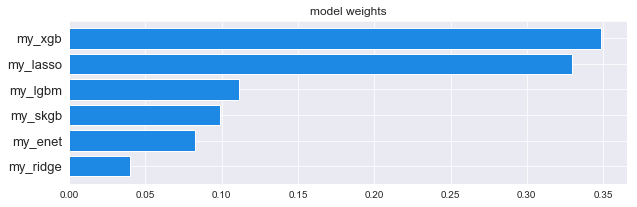

In [100]:
scip.model_weights(my_stackModel)

## X, y cross-validation scores

In [218]:
cv_scores = sci.score_cv(data, min_mean, rmse_score)

CV for MeanModels ..


[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   2 out of   5 | elapsed:   31.4s remaining:   47.1s
[Parallel(n_jobs=11)]: Done   5 out of   5 | elapsed:   31.4s remaining:    0.0s
[Parallel(n_jobs=11)]: Done   5 out of   5 | elapsed:   31.4s finished


,mean,std
MeanModels,0.09273,0.00246


Can't plot with only a single or no samples


## Model hyper-parameter tuning

In [145]:
skrf_search_spaces = {
    'n_estimators': (10, 4000),
#     'criterion': (['gini', 'entropy']),
    'max_depth': (1, 20),
    'min_samples_split': (2, 20),
    'min_samples_leaf': (1, 20),
    'min_weight_fraction_leaf': (0, 0.5, 'uniform'),
    'max_features': (['auto', 'sqrt', 'log2']),
    'min_impurity_decrease': (0, 10, 'uniform'),
#     'bootstrap': ([True, False]),
#     'oob_score': ([True, False]),
    
    # max_leaf_nodes
}

skrf_search_spaces = {
    'n_estimators': (10, 4000),
#     'criterion': (['gini', 'entropy']),
    'max_depth': (2, 10),
    'min_samples_split': (2, 20),
    'min_samples_leaf': (1, 10),
    'min_weight_fraction_leaf': (0, 0.5, 'uniform'),
    'max_features': (['auto', 'sqrt', 'log2']),
    'min_impurity_decrease': (0, 1, 'uniform'),
#     'bootstrap': ([True, False]),
#     'oob_score': ([True, False]),
    
    # max_leaf_nodes
}


Running 100 iterations of BayesSearchCV with '<function neg_rmse_score at 0x1a1f2676a8>' scoring
with cv = <sklearn.model_selection._split.RepeatedKFold object at 0x1a2b6046d8>
with all_data = True
serach_spaces:
{
    'n_estimators': (30, 4000),
    'learning_rate': (0.001, 1.0, 'log-uniform'),
    'max_depth': (1, 20),
    'subsample': (0.01, 1.0, 'uniform'),
    'gamma': (1e-09, 10, 'log-uniform'),
    'min_child_weight': (0, 10),
    'reg_lambda': (1e-09, 1000, 'log-uniform'),
    'reg_alpha': (1e-09, 1.0, 'log-uniform'),
    'colsample_bytree': (0.01, 1.0, 'uniform'),
    'colsample_bylevel': (0.01, 1.0, 'uniform'),
}

mean CV '<function neg_rmse_score at 0x1a1f2676a8>' score: -0.1123
params: {'colsample_bylevel': 0.30514688583882316, 'colsample_bytree': 0.3546474977060259, 'gamma': 0.13577267029864104, 'learning_rate': 0.059816595178142154, 'max_depth': 9, 'min_child_weight': 0, 'n_estimators': 896, 'reg_alpha': 0.1255303516733645, 'reg_lambda': 5.048102185925081, 'subsample': 0.

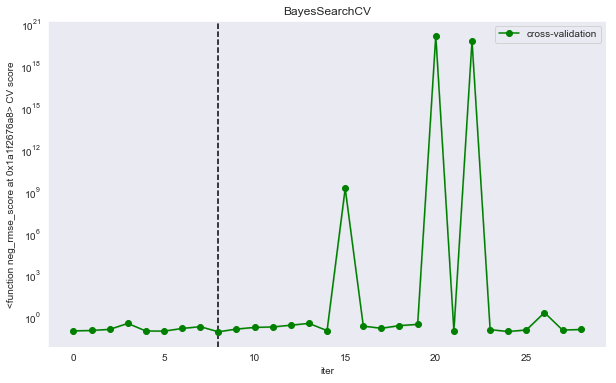

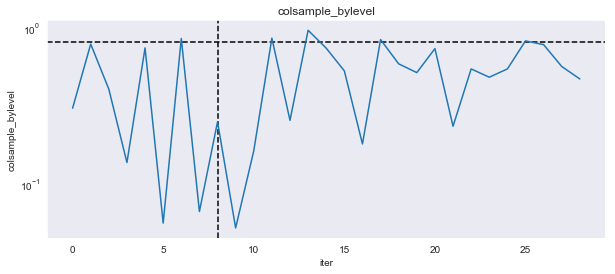

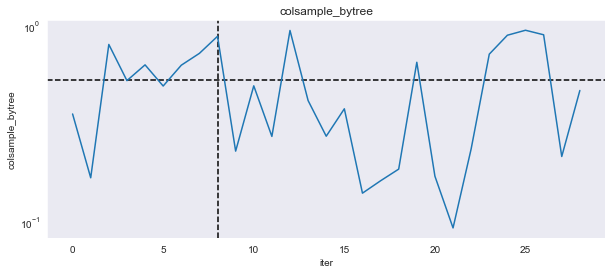

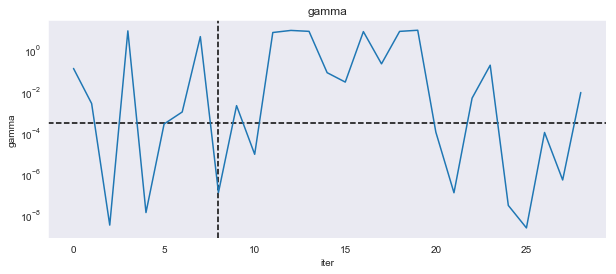

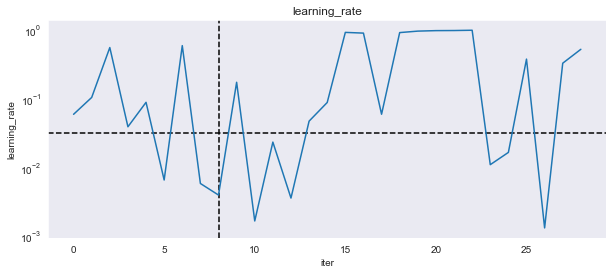

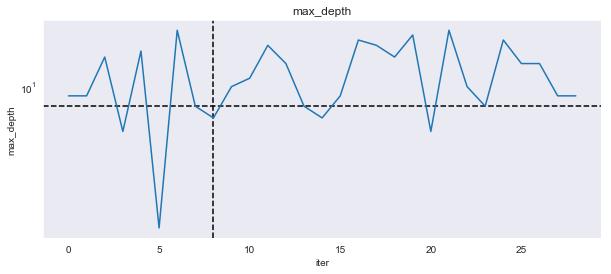

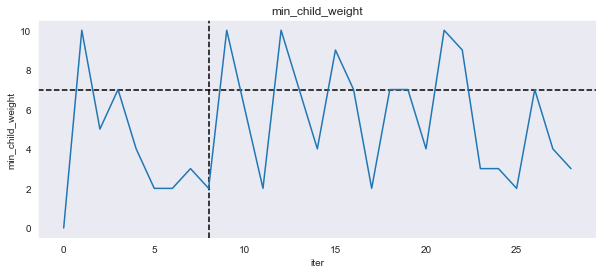

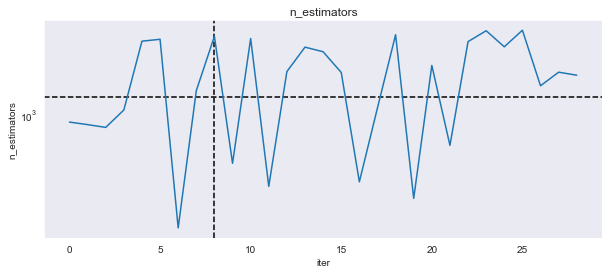

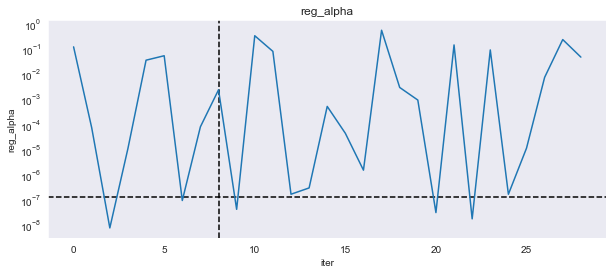

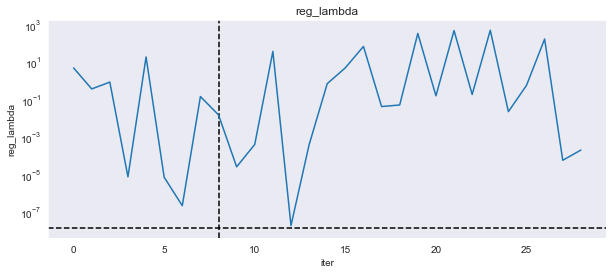

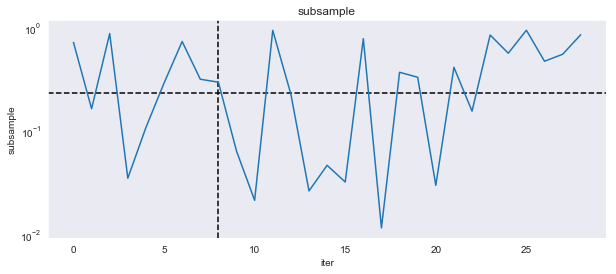

In [216]:
sci.bayes_search(data, min_xgb, scoring=neg_rmse_score, cv=RepeatedKFold(5, 1), all_data=True)


## Incremental Model Selection

In [94]:
# cv = 5
models = models_my
scoring = rmse

try:
    scores = sci.score(data, models, scoring, show=False)
    print('using existing fit for model scores')
except:
    print('fitting to get model scores')
    scores = sci.fit_score(data, models, scoring, show=False)
    
sorted_scores = sorted(scores.items(), key=lambda kv: kv[1])

sub_models = {}
scores_inc = []
names_inc = []
for k, _ in sorted_scores:
    sub_models[k] = models[k]
    meanModel = MeanModels(dict(sub_models), fit_models=False)
    score = sci.fit_score(data, meanModel, scoring, show=False)['MeanModels']
    scores_inc.append(score)
    names_inc.append(k)
    
    
res = pd.Series(scores_inc, index=names_inc)

res
    

fitting to get model scores
fitting my_lasso ..
fitting my_enet ..
fitting my_ridge ..
fitting my_xgb ..
fitting my_lgbm ..
fitting my_skgb ..
fitting MeanModels ..
fitting MeanModels ..
fitting MeanModels ..
fitting MeanModels ..
fitting MeanModels ..
fitting MeanModels ..


my_xgb     0.08429
my_lasso   0.08177
my_lgbm    0.08173
my_enet    0.08165
my_ridge   0.08218
my_skgb    0.08223
dtype: float64

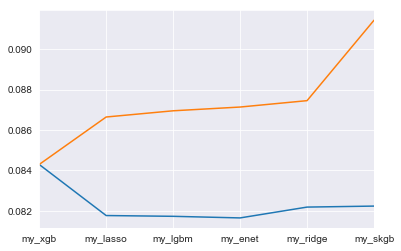

In [95]:
import matplotlib.pyplot as plt
res.plot()
plt.plot([p[1] for p in sorted_scores])

In [97]:
score2 = sci.fit_score(data, my_stackModel, rmse)
score2 = sci.score(data, my_stackModel, rmse, show=False)
score_stack = score2['StackingAveragedModels']

0it [00:00, ?it/s]

fitting StackingAveragedModels ..


5it [01:47, 21.37s/it]


StackingAveragedModels   0.08224
dtype: float64

Can't plot with only a single or no samples


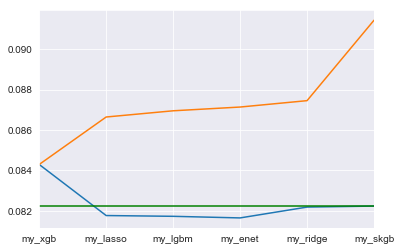

In [99]:
import matplotlib.pyplot as plt
res.plot()
plt.plot([p[1] for p in sorted_scores])

plt.axhline(score_stack, color='g')

## Residuals

In [189]:
model = min_mean

In [104]:
sci.fit(data, model)

fitting MeanModels ..


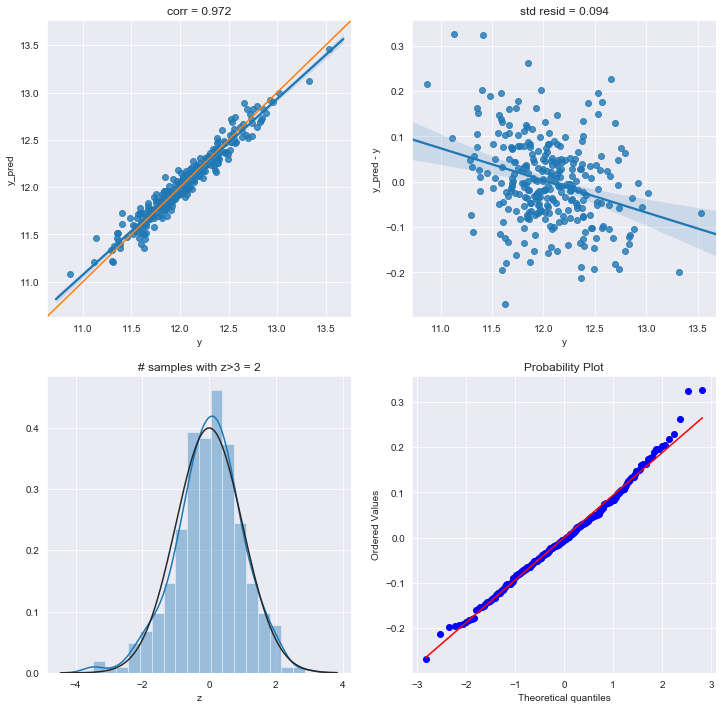

In [190]:
scip.residuals_model(data, model)

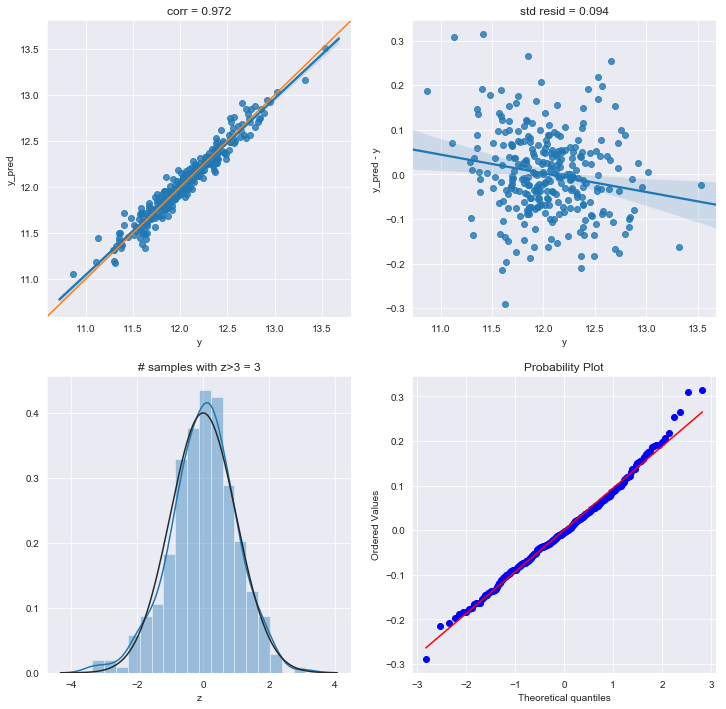

In [191]:
y_pred_fix = sci.fit_transform_residuals(model, data.X_train, data.y_train, X_test=data.X_test)
scip.residuals_y(data.y_test, y_pred_fix)

## Final & Submit

In [229]:
final_model = min_mean
sci.fit(data, final_model, all_data=True)

fitting MeanModels ..


In [230]:
y_pred = final_model.predict(data.X_score)

In [231]:
# this seems to help slightly
y_pred = sci.fit_transform_residuals(final_model, data.X, data.y, y_pred=y_pred)

In [114]:
# # Correct the prediction
# q1 = pd.DataFrame(y_pred).quantile(0.0042)
# pre_df = pd.DataFrame(y_pred)
# pre_df["SalePrice"] = y_pred
# pre_df = pre_df[["SalePrice"]]
# pre_df.loc[pre_df.SalePrice <= q1[0], "SalePrice"] = pre_df.loc[pre_df.SalePrice <= q1[0], "SalePrice"] *0.96
# y_pred = pre_df.SalePrice

In [232]:
# transform back to target units
import numpy as np
y_pred = np.expm1(y_pred)

In [116]:
# y_pred = (y_pred/1000).round()*1000 # round to nearest 1000's - this didn't change anything ?????

In [117]:
# from scipy.special import inv_boxcox
# y_pred = inv_boxcox(y_pred, boxcox_lambda)

In [233]:
# save submission using samples Ids
index = pd.read_csv('data/sample_submission.csv')["Id"]
df_score = pd.DataFrame({"Id": index, "SalePrice": y_pred})
df_score.to_csv('data/submission.csv', index=False)